## There are other normalization layers available in PyTorch. Try them out and see what works best. Learn about why other normalization layers have been developed, and how they differ from batch normalization.

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [ ]:
def get_dls(bs=64):
    return DataBlock(
        blocks = (ImageBlock(cls = PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter('training', 'testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

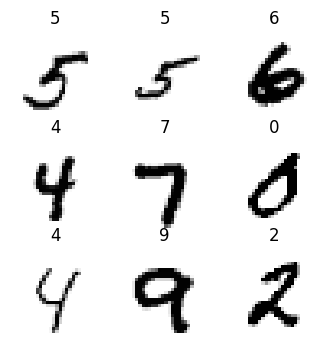

In [ ]:
dls.show_batch(max_n=9, figsize=(4,4))

In [ ]:
def simple_cnn():
    return sequential(
        conv(1, 8, ks=5),
        conv(8, 16),
        conv(16, 32),
        conv(32, 64),
        conv(64, 10, act=False),
        Flatten()
    )

In [ ]:
def fit(epochs = 1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=CrossEntropyLossFlat(),
                    metrics=accuracy)
    learn.fit_one_cycle(epochs, lr)
    return learn

**Description**<br>
`BatchNorm2d` for normalizing the activations of convolutional layers. It computes the mean and standard deviation of each feature map across a mini-batch of data and normalizes the activations accordingly. Additionally, BatchNorm2d introduces learnable parameters (weight and bias) that allow the network to adjust the normalized activations during training. 
During inference a running avg and std deviation is used.

In [ ]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    layers.append(nn.BatchNorm2d(nf))
    if act:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)
learn = fit(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.106958,0.060751,0.979800,00:28
1,0.045697,0.030825,0.990200,00:31


In [ ]:
m1 = learn.model
m1[0]

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

In [ ]:
m1[0][1].weight, m1[0][1].bias

(Parameter containing:
 tensor([1.1920, 3.3186, 3.0053, 1.7383, 1.1658, 1.8330, 1.5459, 3.0281],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.5849,  0.1569,  0.3826,  0.5174, -0.1117, -0.2501, -1.4828, -0.6511],
        requires_grad=True))

**Description**<br>
`LazyBatchNorm2d` is a lightweight alternative to BatchNorm2d. Unlike `BatchNorm2d`, it does not have learnable parameters (such as weight and bias) and relies solely on input statistics for normalization.

**Benefits**<br>
*Memory Efficiency*: Since LazyBatchNorm2d does not require additional memory for learnable parameters, it is more memory-efficient compared to BatchNorm2d.<br>
*Simplified Implementation*: By avoiding the introduction of learnable parameters, LazyBatchNorm2d simplifies the implementation of neural network architectures, making it easier to manage and optimize.

In [ ]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    layers.append(nn.LazyBatchNorm2d())
    if act:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)
learn = fit(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.123992,0.081495,0.976000,00:29
1,0.047296,0.033676,0.990200,00:31


In [ ]:
m1 = learn.model
m1[0]

ConvLayer(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): BatchNorm2d(8, eps=8, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

In [ ]:
m1[0][1].weight, m1[0][1].bias

(Parameter containing:
 tensor([1.5497, 2.4985, 1.1268, 1.8460, 1.3437, 2.1818, 1.0804, 1.0803],
        requires_grad=True),
 Parameter containing:
 tensor([-0.5212,  0.4667, -1.6717,  0.1338,  0.6302, -0.2084, -0.7283,  0.3781],
        requires_grad=True))

**GroupNorm**<br>
Applies Group Normalization over a mini-batch of inputs.<br>
The mean and standard-deviation are calculated separately over the each group. γ and β are learnable per-channel affine transform parameter vectors of size num_channels if affine is True.

*Defination* : torch.nn.GroupNorm(num_groups, num_channels, eps=1e-05, affine=True, device=None, dtype=None) <br>
`num_channels` should be devisible by `num_groups`

In [ ]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    layers.append(nn.GroupNorm(2, nf))
    if act:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)
learn = fit(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.159094,0.123100,0.970400,00:28
1,0.062155,0.057904,0.985500,00:31


In [ ]:
m1 = learn.model
m1[0]

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): GroupNorm(2, 8, eps=1e-05, affine=True)
  (2): ReLU()
)

In [ ]:
m1[0][1].weight, m1[0][1].bias

(Parameter containing:
 tensor([1.0456, 0.9250, 1.7239, 1.5443, 1.6327, 0.9341, 1.1175, 1.3761],
        requires_grad=True),
 Parameter containing:
 tensor([-0.4639, -0.1354,  0.0647, -0.0583, -0.2727, -0.2239, -0.5266, -0.4883],
        requires_grad=True))

In [ ]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    layers.append(nn.InstanceNorm2d(nf))
    if act:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)
learn = fit(2)

epoch,train_loss,valid_loss,accuracy,time


ValueError: Expected more than 1 spatial element when training, got input size torch.Size([64, 10, 1, 1])

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]

In [ ]:
t1 = torch.randn((2,3))
t2 = torch.randn((2,3))
t1.m